In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uci-sms-spam-collection-data-set/readme
/kaggle/input/uci-sms-spam-collection-data-set/SMSSpamCollection


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
%matplotlib inline
sns.set()

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
df = pd.read_csv("../input/uci-sms-spam-collection-data-set/SMSSpamCollection", sep="\t", names=["labels", "messages"])

In [5]:
df.head()

,labels,messages
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    5572 non-null   object
 1   messages  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
df.describe(include="all")

,labels,messages
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [8]:
df.groupby('labels').describe(include='all')

messages                                                               
          count unique                                                top freq
labels                                                                        
ham        4825   4516                             Sorry, I'll call later   30
spam        747    653  Please call our customer service representativ...    4

In [9]:
df['msg_length']=df['messages'].apply(len)

In [10]:
df.head()

,labels,messages,msg_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='msg_length', ylabel='Density'>

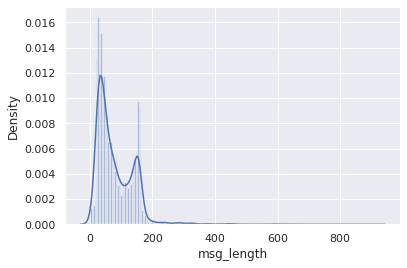

In [11]:
sns.distplot(df['msg_length'], bins=200)

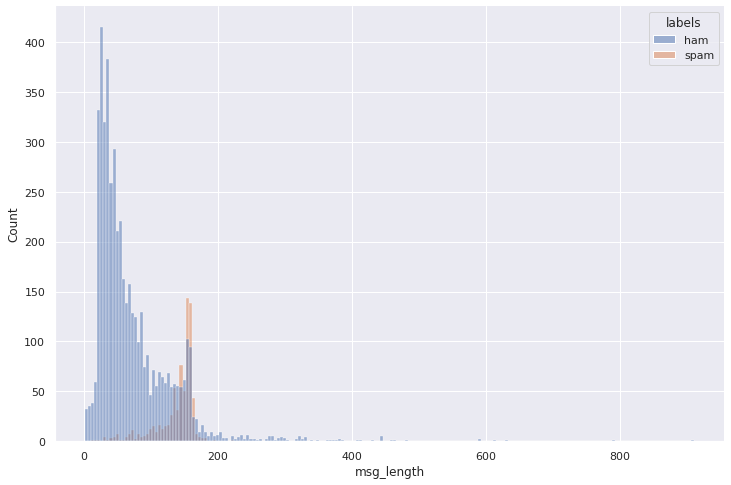

In [12]:
plt.figure(figsize=(12,8))
sns.histplot(data=df, x='msg_length', hue='labels', bins=200)
sns.despine()

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

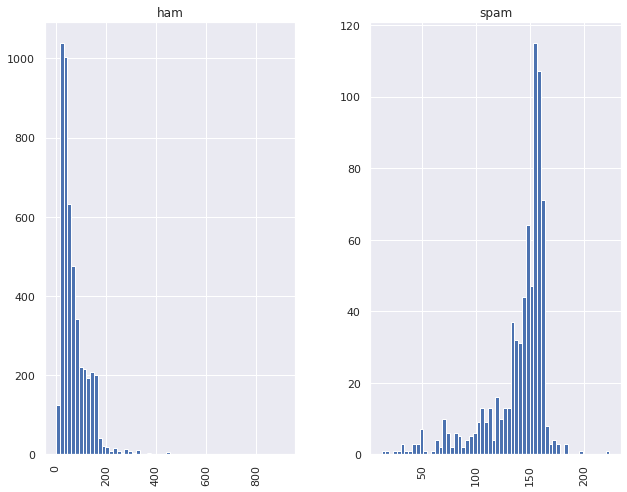

In [13]:
df.hist(column='msg_length',by='labels', figsize=(10,8), bins=60)

In [14]:
df[df["msg_length"]==910]["messages"]

1085    For me the love should start with attraction.i...
Name: messages, dtype: object

In [15]:
sample = df[df["msg_length"]==910]["messages"].iloc[0]

In [16]:
sample

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [17]:
sd1 = [y.split() for y in sample.lower().split(".")]

word_vec = []
for i in sd1:
    
    w = [j for j in i if j not in stopwords.words("english")]
    for g in w:
        word_vec.append(g)
print(word_vec)

['love', 'start', 'attraction', 'feel', 'need', 'every', 'time', 'around', 'first', 'thing', 'comes', 'thoughts', 'would', 'start', 'day', 'end', 'every', 'time', 'dream', 'love', 'every', 'breath', 'name', 'life', 'happen', 'around', 'life', 'named', 'would', 'cry', 'give', 'happiness', 'take', 'sorrows', 'ready', 'fight', 'anyone', 'love', 'craziest', 'things', 'love', 'proove', 'anyone', 'girl', 'beautiful', 'lady', 'whole', 'planet', 'always', 'singing', 'praises', 'love', 'start', 'making', 'chicken', 'curry', 'end', 'makiing', 'sambar', 'life', 'beautiful', 'get', 'every', 'morning', 'thank', 'god', 'day', 'would', 'like', 'say', 'lot', 'tell', 'later']


In [18]:
bow_mess = CountVectorizer().fit_transform(word_vec)

In [19]:
print(bow_mess)

  (0, 29)	1
  (1, 44)	1
  (2, 3)	1
  (3, 15)	1
  (4, 35)	1
  (5, 14)	1
  (6, 51)	1
  (7, 2)	1
  (8, 17)	1
  (9, 48)	1
  (10, 7)	1
  (11, 50)	1
  (12, 53)	1
  (13, 44)	1
  (14, 11)	1
  (15, 13)	1
  (16, 14)	1
  (17, 51)	1
  (18, 12)	1
  (19, 29)	1
  (20, 14)	1
  (21, 5)	1
  (22, 33)	1
  (23, 26)	1
  (24, 22)	1
  :	:
  (48, 0)	1
  (49, 42)	1
  (50, 37)	1
  (51, 29)	1
  (52, 44)	1
  (53, 31)	1
  (54, 6)	1
  (55, 10)	1
  (56, 13)	1
  (57, 30)	1
  (58, 40)	1
  (59, 26)	1
  (60, 4)	1
  (61, 18)	1
  (62, 14)	1
  (63, 32)	1
  (64, 47)	1
  (65, 21)	1
  (66, 11)	1
  (67, 53)	1
  (68, 27)	1
  (69, 41)	1
  (70, 28)	1
  (71, 46)	1
  (72, 25)	1


In [20]:
def text_prepros(message):
    sd1 = [y.split() for y in message.lower().split(".")]
    word_vec = []
    for i in sd1:
        w = [j for j in i if j not in stopwords.words("english")]
        for g in w:
            word_vec.append(g)
    return word_vec

In [21]:
df["messages"].head(5).apply(text_prepros)

0    [go, jurong, point,, crazy, available, bugis, ...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4      [nah, think, goes, usf,, lives, around, though]
Name: messages, dtype: object

In [22]:
bow_mess = CountVectorizer(analyzer=text_prepros).fit(df["messages"])

In [23]:
mess_1085 = df["messages"][1085]
mess_1085

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

In [24]:
bow_1085 = bow_mess.transform([mess_1085])

In [25]:
print(bow_1085)

  (0, 1557)	1
  (0, 1638)	2
  (0, 1735)	2
  (0, 1827)	1
  (0, 2041)	2
  (0, 2345)	1
  (0, 2769)	1
  (0, 2954)	1
  (0, 3157)	1
  (0, 3196)	1
  (0, 3230)	1
  (0, 3324)	2
  (0, 3688)	1
  (0, 3887)	2
  (0, 4001)	4
  (0, 4182)	1
  (0, 4216)	1
  (0, 4269)	1
  (0, 4626)	1
  (0, 4654)	1
  (0, 4664)	1
  (0, 4696)	1
  (0, 4917)	1
  (0, 4930)	1
  (0, 5917)	1
  :	:
  (0, 6245)	5
  (0, 6374)	1
  (0, 6376)	1
  (0, 6738)	1
  (0, 6887)	1
  (0, 6892)	1
  (0, 6932)	1
  (0, 7681)	1
  (0, 7849)	1
  (0, 7983)	1
  (0, 8168)	1
  (0, 8573)	1
  (0, 8621)	1
  (0, 8950)	1
  (0, 9162)	1
  (0, 9317)	3
  (0, 9652)	1
  (0, 9736)	1
  (0, 9798)	1
  (0, 9868)	1
  (0, 9872)	1
  (0, 9910)	1
  (0, 9951)	2
  (0, 10812)	1
  (0, 10977)	3


In [26]:
bow_mess.get_feature_names()[6245]

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'love'

## Data Splitting and Pipeline creation

In [27]:
msg_train, msg_test, label_train, label_test = train_test_split(df['messages'], df['labels'], test_size=0.30)

### Classification using Naive Bayes classifier

In [28]:
pipeline = Pipeline([
    ('bow_mess', CountVectorizer(analyzer=text_prepros)),
    ('tfidf_form', TfidfTransformer()),
    ('classifier', MultinomialNB())
])

In [29]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow_mess',
                 CountVectorizer(analyzer=<function text_prepros at 0x7f0a47ce73b0>)),
                ('tfidf_form', TfidfTransformer()),
                ('classifier', MultinomialNB())])

#### Predictions and assessing model accuracy 

In [30]:
prediction = pipeline.predict(msg_test)

In [31]:
print(classification_report(label_test, prediction))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.98      1430
        spam       1.00      0.70      0.83       242

    accuracy                           0.96      1672
   macro avg       0.98      0.85      0.90      1672
weighted avg       0.96      0.96      0.95      1672



### Classification using RandomForest Classifier

In [32]:
pipeline2 = Pipeline([
    ('bow_mess', CountVectorizer(analyzer=text_prepros)),
    ('tfidf_form', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

In [33]:
pipeline2.fit(msg_train, label_train)

Pipeline(steps=[('bow_mess',
                 CountVectorizer(analyzer=<function text_prepros at 0x7f0a47ce73b0>)),
                ('tfidf_form', TfidfTransformer()),
                ('classifier', RandomForestClassifier())])

#### Predictions and assessing model accuracy 

In [34]:
prediction2 = pipeline2.predict(msg_test)

In [35]:
print(classification_report(label_test, prediction2))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1430
        spam       1.00      0.78      0.87       242

    accuracy                           0.97      1672
   macro avg       0.98      0.89      0.93      1672
weighted avg       0.97      0.97      0.97      1672



### Classification using LogisticRegression

In [36]:
pipeline3 = Pipeline([
    ('bow_mess', CountVectorizer(analyzer=text_prepros)),
    ('tfidf_form', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

In [37]:
pipeline3.fit(msg_train, label_train)

Pipeline(steps=[('bow_mess',
                 CountVectorizer(analyzer=<function text_prepros at 0x7f0a47ce73b0>)),
                ('tfidf_form', TfidfTransformer()),
                ('classifier', LogisticRegression())])

#### Prediction & assessment

In [38]:
prediction3 = pipeline3.predict(msg_test)

In [39]:
print(classification_report(label_test, prediction3))

              precision    recall  f1-score   support

         ham       0.95      1.00      0.97      1430
        spam       0.98      0.68      0.80       242

    accuracy                           0.95      1672
   macro avg       0.97      0.84      0.89      1672
weighted avg       0.95      0.95      0.95      1672



In [40]:
from sklearn.ensemble import VotingClassifier

In [41]:
c_1 = MultinomialNB()

In [42]:
c_2 = RandomForestClassifier(random_state=1)

In [43]:
c_3 = LogisticRegression(random_state = 1)

In [44]:
final_predict = VotingClassifier(estimators=[('Nb',c_1),('Rf',c_2),('Lr',c_3)], voting = 'hard')

In [45]:
pipeline_ensemble = Pipeline([
    ('bow_mess', CountVectorizer(analyzer=text_prepros)),
    ('tfidf_form', TfidfTransformer()),
    ('classifier', VotingClassifier(estimators=[('Nb',c_1),('Rf',c_2),('Lr',c_3)], voting = 'hard'))
])

In [46]:
pipeline_ensemble.fit(msg_train, label_train)

Pipeline(steps=[('bow_mess',
                 CountVectorizer(analyzer=<function text_prepros at 0x7f0a47ce73b0>)),
                ('tfidf_form', TfidfTransformer()),
                ('classifier',
                 VotingClassifier(estimators=[('Nb', MultinomialNB()),
                                              ('Rf',
                                               RandomForestClassifier(random_state=1)),
                                              ('Lr',
                                               LogisticRegression(random_state=1))]))])

In [47]:
pipeline_ensemble.score(msg_test, label_test)

0.9635167464114832

In [48]:
final_predict = pipeline_ensemble.predict(msg_test)

In [49]:
print(classification_report(label_test,final_predict))

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      1430
        spam       1.00      0.75      0.86       242

    accuracy                           0.96      1672
   macro avg       0.98      0.87      0.92      1672
weighted avg       0.97      0.96      0.96      1672



In [50]:
sd = [x for x in sample if x not in string.punctuation]
sd = "".join(sd)
sd1 = [y for y in sd.split() if y.lower() not in stopwords.words("english")]
print(sd1)

['love', 'start', 'attractioni', 'feel', 'need', 'every', 'time', 'around', 'meshe', 'first', 'thing', 'comes', 'thoughtsI', 'would', 'start', 'day', 'end', 'hershe', 'every', 'time', 'dreamlove', 'every', 'breath', 'namemy', 'life', 'happen', 'around', 'hermy', 'life', 'named', 'herI', 'would', 'cry', 'herwill', 'give', 'happiness', 'take', 'sorrowsI', 'ready', 'fight', 'anyone', 'herI', 'love', 'craziest', 'things', 'herlove', 'dont', 'proove', 'anyone', 'girl', 'beautiful', 'lady', 'whole', 'planetI', 'always', 'singing', 'praises', 'herlove', 'start', 'making', 'chicken', 'curry', 'end', 'makiing', 'sambarlife', 'beautiful', 'thenwill', 'get', 'every', 'morning', 'thank', 'god', 'day', 'meI', 'would', 'like', 'say', 'lotwill', 'tell', 'later']
